In [1]:
# for online added package use
using qsrfe

  Activating project at `c:\Users\grsbe\Desktop\Masterthesis\qsrfe`


In [1]:
# for local package use
include("src/qsrfe.jl")
using .qsrfe
using Plots

In [2]:
#2^8 = 256, 2^9 = 512, 2^10 = 1024, 2^11 = 2048, 2^12 = 4096, 2^13 = 8192, 2^14 = 16384
N = 2^8
λ = 0.003
MSQ2 = MSQ(K=2)
MSQ4 = MSQ(K=16)
MSQ8 = MSQ(K=256)

λ_c = 16
p = N ÷ λ_c
model2 = srfeRegressor(N= p*λ_c,λ=λ, σ2=1.0)

ΣΔ1Q2 = ΣΔQ(K=2,r=1,λ=λ_c,condense=true)
ΣΔ1Q4 = ΣΔQ(K=16,r=1,λ=λ_c,condense=true)
ΣΔ1Q8 = ΣΔQ(K=256,r=1,λ=λ_c,condense=true)

βQ2 = βQ(K=2,β=1.5,λ=λ_c,condense=true)
βQ4 = βQ(K=16,β=1.5,λ=λ_c,condense=true)
βQ8 = βQ(K=256,β=1.5,λ=λ_c,condense=true);

In [3]:
#boston dataset
using LinearAlgebra
using MLJ, MLJLinearModels
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = load_dataset(X,Y;normalize=true,partitioning=0.8,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 47
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest])

(([0.0005258688489131264 0.0428728179250255 … 0.04792704786097089 0.02059703773458206; 0.08821644274022668 0.0 … 0.04792704786097089 0.11620646698099267; … ; 0.00013014383682632827 0.0 … 0.04743558128300629 0.012333738792030565; 0.0006105171854344649 0.0 … 0.04772659711909835 0.03755210297226179], [0.0015519497551627708 0.0 … 0.04792704786097089 0.04710080397254352; 0.001380840892380482 0.0 … 0.04213450443469029 0.09043721620459136; … ; 0.007135830924146997 0.0 … 0.04124938158051816 0.040643188872994014; 0.0024826045648607543 0.0 … 0.046906681132764284 0.029196989597015277]), ([22.2, 13.8, 22.0, 14.6, 27.5, 25.3, 12.7, 14.4, 12.7, 25.0  …  13.4, 23.3, 22.8, 33.4, 23.5, 10.4, 20.6, 20.5, 34.7, 19.8], [18.0, 23.7, 8.1, 29.6, 44.0, 33.1, 8.3, 21.4, 22.6, 29.0  …  23.4, 20.3, 10.5, 22.9, 16.7, 19.9, 15.7, 21.4, 19.6, 25.1]))

In [7]:
length(ytrain), length(ytest), length(ytrain)+ length(ytest)

(389, 98, 487)

In [ ]:
#other datasets here

In [49]:
#test cell for hyperparameter testing
#model = model
N= 2^11
λ = 0.003
model = srfeRegressor(N=N,λ=λ, σ2=11.0)

c, ω, ζ = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=true)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
ytestpred = qsrfe.predict(model,xtest,c, ω, ζ);

println("")
println("rel: ",rel_error(ytest,ytestpred)," train rel: ",rel_error(ytrain,ytrainpred))
println("abs: ",abs_error(ytest,ytestpred)," train abs: ",abs_error(ytrain,ytrainpred))
println("mse: ",mse(ytest,ytestpred)," train mse: ",mse(ytrain,ytrainpred))

support: 403/2048


rel: 0.10026120021864819 train rel: 0.06915479029606407
abs: 2.0177683941595066 train abs: 1.2643487826371846
mse: 7.9432554388529555 train mse: 2.871883902387265


In [31]:
using HyperTuning
function objective(trial)
    @unpack λ, σ2 = trial
    model = srfeRegressor(N=2^9,λ=λ, σ2=σ2,intercept=false)
    c, ω, ζ = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=false)
    ytestpred = qsrfe.predict(model,xtest,c, ω, ζ)
    return mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.001..0.006),
                        σ2 = (5.0..20.0),
                        max_trials = 100);

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 100 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 8
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 100
           max_evals: 100
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬────────────┐
│     Trial │      Value │
│       100 │            │
├───────────┼────────────┤
│         λ │ 0.00161612 │
│        σ2 │    11.0289 │
│    Pruned │      false │
│   Success │      false │
│ Objective │     6.9526 │
└───────────┴────────────┘


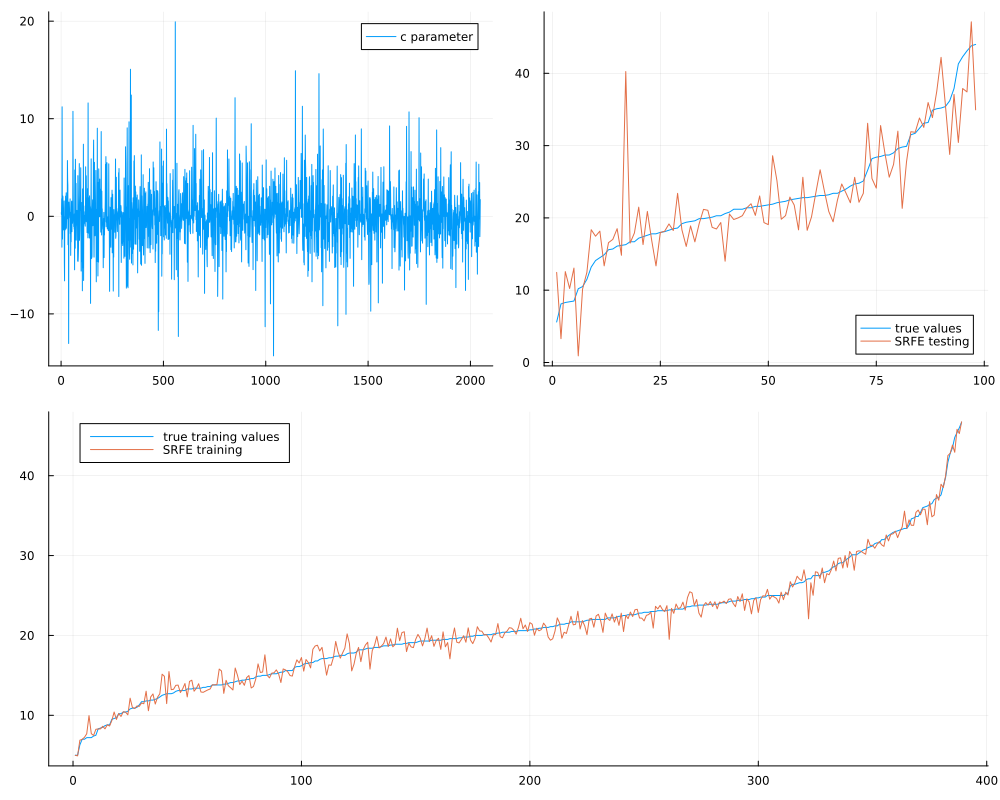

In [43]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [6]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128

: avg. test error: 0.10721052984360054 avg. train error: 0.09144475901796002
abs. test error:2.1695044281239215 abs. train error: 1.6822767936282013
mse. test error:9.490232448682166 mse train error: 4.7997029939351155
rel mse test error:0.012812818512026262 rel mse train error: 0.004962740328255848
current iter: 256

: avg. test error: 0.10535615914517579 avg. train error: 0.08387193276289029
abs. test error:2.129118039695242 abs. train error: 1.5403811599285755
mse. test error:8.835892551930595 mse train error: 4.1879098768406955
rel mse test error:0.012366453343942468 rel mse train error: 0.00463584161946854
current iter: 512: 

avg. test error: 0.09847837467973494 avg. train error: 0.07746699299005884
abs. test error:1.9999980848754735 abs. train error: 1.420443441040084
mse. test error:7.954443907867878 mse train error: 3.6118765845719656
rel mse test error:0.011736275006711367 rel mse train error: 0.004305547350467975
current iter: 1024: 

avg. test error: 0.10030634787690862 avg. train error: 0.0738640916730227
abs. test error:2.0033209094102844 abs. train error: 1.3553362770764288
mse. test error:7.816227849625861 mse train error: 3.2843880988927503
rel mse test error:0.011631466477257785 rel mse train error: 0.004105716898627007
current iter: 2048

: avg. test error: 0.09893716144366921 avg. train error: 0.07123870345788079
abs. test error:1.969214867773961 abs. train error: 1.307904327357586
mse. test error:7.619169763636135 mse train error: 3.0864445765942463
rel mse test error:0.011487054558629204 rel mse train error: 0.003979873412503146
current iter: 4096: 

avg. test error: 0.09782371246330054 avg. train error: 0.06784025512881713
abs. test error:1.9563474848660989 abs. train error: 1.2444220579828875
mse. test error:7.450707408087605 mse train error: 2.856799339468455
rel mse test error:0.011358156170422042 rel mse train error: 0.0038290285054384436
current iter: 8192: avg. test error: 

0.0990875023819248 avg. train error: 0.06608359440373049
abs. test error:1.9857213197009156 abs. train error: 1.2088475642683716
mse. test error:7.80135597194617 mse train error: 2.6957059452957925
rel mse test error:0.011617745469349922 rel mse train error: 0.0037194275484876416
current iter: 16384

: avg. test error: 0.10012388729305197 avg. train error: 0.06390082940844939
abs. test error:2.0033688314907843 abs. train error: 1.1700567245092495
mse. test error:7.733718193526974 mse train error: 2.5011737852749034
rel mse test error:0.011573115076085654 rel mse train error: 0.003582908555091272


1.0e-5:3.413793103448276e-5:0.001

In [207]:
#test cell for hyperparameter testing quantized version
# 2^7 = 128, 2^8 = 256, 2^9 = 512, 2^10 =1024, 2^11 = 2048, 2^12 4096, 2^13 8192, 2^14 = 16384, 2^15 = 32768
N= 2^14
λ = 0.00012
#quant = MSQ(K=2)
quant = βQ(K=2,β=1.5,λ=32,condense=true)
#quant = ΣΔQ(K=2,r=1,λ=32,condense=true)
model = srfeRegressor(N=N,λ=λ, σ2=10.0)

c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quant;max_iter=2000000,verbose=true)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ,quant)
ytestpred = qsrfe.predict(model,xtest,c, ω, ζ,quant);

println("")
println("rel: ",rel_error(ytest,ytestpred)," train rel: ",rel_error(ytrain,ytrainpred))
println("abs: ",abs_error(ytest,ytestpred)," train abs: ",abs_error(ytrain,ytrainpred))
println("mse: ",mse(ytest,ytestpred)," train mse: ",mse(ytrain,ytrainpred))

support: 202/512


rel: 0.09813571095695266 train rel: 0.07399656063700125
abs: 1.9522440273234354 train abs: 1.346416336153064
mse: 7.7546315792923535 train mse: 3.3028109436633692


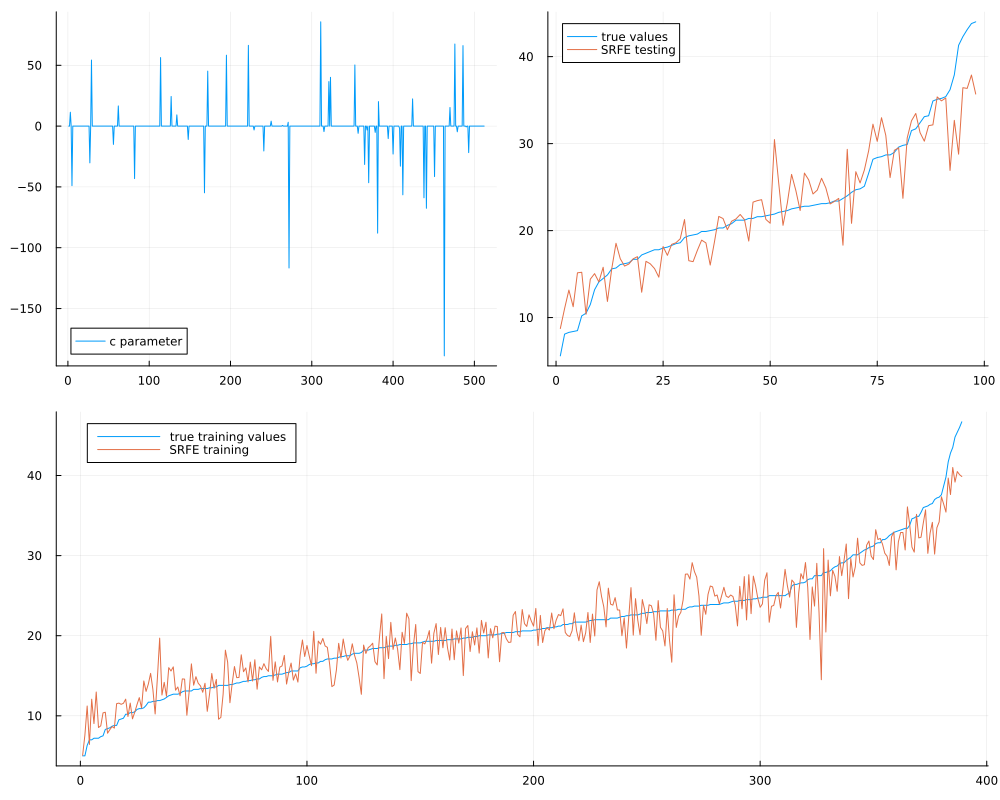

In [198]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [57]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = MSQ(K=2)
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.18099258168203494 avg. train error: 0.11561615018581517
abs. test error:3.7285816445198976 abs. train error: 2.26885725821212
mse. test error:24.793618418792626 mse train error: 9.09344709525352
rel mse test error:0.020692418659477792 rel mse train error: 0.006821568688877876
current iter: 256: 

avg. test error: 0.17525568377222808 avg. train error: 0.08111693748266244
abs. test error:3.550524726766929 abs. train error: 1.575850970882557
mse. test error:22.90129855006998 mse train error: 4.280929413811765
rel mse test error:0.019854862233487723 rel mse train error: 0.004674139735617982
current iter: 512

: avg. test error: 0.2193465252058004 avg. train error: 0.03305146119887767
abs. test error:4.251378023888444 abs. train error: 0.6409110093457677
mse. test error:31.213828556801264 mse train error: 0.7426117391604821
rel mse test error:0.02324196497830347 rel mse train error: 0.0019429252842465283
current iter: 1024: 

avg. test error: 0.17024705585250982 avg. train error: 0.012677419733779024
abs. test error:3.4020576981777912 abs. train error: 0.2424395368342324
mse. test error:19.690763794129246 mse train error: 0.09920078775664656
rel mse test error:0.018446870580686364 rel mse train error: 0.0007128652879042682
current iter: 2048

: avg. test error: 0.15156432011648843 avg. train error: 0.007867026629701821
abs. test error:3.118182421741357 abs. train error: 0.14882219382122203
mse. test error:16.9725243074364 mse train error: 0.037041484939740285
rel mse test error:0.017126665808853053 rel mse train error: 0.0004357268186219532
current iter: 4096: 

avg. test error: 0.13185305369514436 avg. train error: 0.005508956158966906
abs. test error:2.795718474610546 abs. train error: 0.10359925116998929
mse. test error:15.195202862611282 mse train error: 0.018016858457824445
rel mse test error:0.016182560850019727 rel mse train error: 0.00030398852255143153
current iter: 8192: 

avg. test error: 0.13280522421995306 avg. train error: 0.004384881953190352
abs. test error:2.6816375117106293 abs. train error: 0.08180308859690133
mse. test error:13.180825472844143 mse train error: 0.011220986869743778
rel mse test error:0.015100897084896819 rel mse train error: 0.0002397925542804925
current iter: 16384: 

avg. test error: 0.12173111170593727 avg. train error: 0.0035921122851845567
abs. test error:2.5813741930779033 abs. train error: 0.06760485777368155
mse. test error:12.486710539188152 mse train error: 0.007553455622630284
rel mse test error:0.01469972395654262 rel mse train error: 0.00019686689353407553


In [133]:
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = MSQ(K=16)
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.12624377296051095 avg. train error: 0.07707580200247174
abs. test error:2.572620161878887 abs. train error: 1.427718077275801
mse. test error:11.412752481374302 mse train error: 3.4635422969231215
rel mse test error:0.014045909648632273 rel mse train error: 0.004213066390349708
current iter: 512: 

avg. test error: 0.11905912393446536 avg. train error: 0.05707139616107949
abs. test error:2.3937514239240563 abs. train error: 1.0642035386354984
mse. test error:10.441154083776542 mse train error: 1.9361178791480058
rel mse test error:0.013443597352794772 rel mse train error: 0.003150727795592052
current iter: 1024: 

avg. test error: 0.11886010621056686 avg. train error: 0.044897988885493366
abs. test error:2.394149399541737 abs. train error: 0.825364132477055
mse. test error:10.575541950364805 mse train error: 1.201109859546943
rel mse test error:0.01352290322082569 rel mse train error: 0.0024825520641442176
current iter: 2048: 

avg. test error: 0.11591972618051609 avg. train error: 0.036930790286370266
abs. test error:2.318201284859228 abs. train error: 0.6747866158947998
mse. test error:9.854830832385145 mse train error: 0.8011478488096089
rel mse test error:0.013060917169527514 rel mse train error: 0.0020274316033558116
current iter: 4096: 

avg. test error: 0.11359802675596946 avg. train error: 0.030357460644808442
abs. test error:2.244008430127513 abs. train error: 0.560438133959227
mse. test error:9.341474527406405 mse train error: 0.5518126967920678
rel mse test error:0.012716735464842168 rel mse train error: 0.001682557154323406
current iter: 8192

: avg. test error: 0.1043263489968923 avg. train error: 0.026716636138958905
abs. test error:2.149521919352475 abs. train error: 0.49411237110316175
mse. test error:8.596166143559183 mse train error: 0.43191340895147406
rel mse test error:0.01218555912715535 rel mse train error: 0.0014888163670467324
current iter: 16384: 

avg. test error: 0.10645806046606299 avg. train error: 0.024109820272827376
abs. test error:2.1482184113885148 abs. train error: 0.4445914827245228
mse. test error:8.694910639505787 mse train error: 0.35623293056498906
rel mse test error:0.012268444826827433 rel mse train error: 0.0013519415125301918


In [134]:
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = MSQ(K=256)
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256

: avg. test error: 0.10213088543078161 avg. train error: 0.0820349475526332
abs. test error:2.044290932317101 abs. train error: 1.5010137444199259
mse. test error:8.223258181830932 mse train error: 3.9863927137721715
rel mse test error:0.011932987173691172 rel mse train error: 0.00452263871030676
current iter: 512

: avg. test error: 0.10382061020628235 avg. train error: 0.078002322720968
abs. test error:2.082867772859872 abs. train error: 1.4301064265499177
mse. test error:8.406095102182253 mse train error: 3.6514627833558024
rel mse test error:0.012067229619105465 rel mse train error: 0.0043286491986335735
current iter: 1024

: avg. test error: 0.0984567848770878 avg. train error: 0.07472903720821751
abs. test error:1.9863361552323429 abs. train error: 1.368206734234548
mse. test error:7.943946386964164 mse train error: 3.3386182435068448
rel mse test error:0.011725169254000755 rel mse train error: 0.004138991461410279
current iter: 2048

: avg. test error: 0.09841103696241309 avg. train error: 0.07049718082580844
abs. test error:1.9854371604329137 abs. train error: 1.284070113295797
mse. test error:7.681225826530429 mse train error: 2.979885661251191
rel mse test error:0.011533899529227246 rel mse train error: 0.003910666888667169
current iter: 4096: 

avg. test error: 0.09710974828778308 avg. train error: 0.06790379277651332
abs. test error:1.9690273040472956 abs. train error: 1.2395904579317905
mse. test error:7.650493316951939 mse train error: 2.8055149733227123
rel mse test error:0.01151109926821614 rel mse train error: 0.003794617601227912
current iter: 8192

: avg. test error: 0.09885788575048177 avg. train error: 0.06549319395062606
abs. test error:1.9744388263626358 abs. train error: 1.2016350168746344
mse. test error:7.542003282600449 mse train error: 2.653684457718075
rel mse test error:0.011430221341255124 rel mse train error: 0.0036904934360646536
current iter: 16384: 

avg. test error: 0.10068893230304929 avg. train error: 0.06397820719594662
abs. test error:1.9982596577148144 abs. train error: 1.1762206365015622
mse. test error:7.661415325684319 mse train error: 2.515545483133882
rel mse test error:0.011518654633935041 rel mse train error: 0.0035930110585367645


In [58]:
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003
quant = ΣΔQ(K=1,r=1,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128

: avg. test error: 0.2707409683872607 avg. train error: 0.30564940153241804
abs. test error:5.7927731310792705 abs. train error: 5.714019019967357
mse. test error:63.61054245900338 mse train error: 56.21478832154874
rel mse test error:0.0328650403830273 rel mse train error: 0.016769728936986698
current iter: 256

: avg. test error: 0.2157314446750896 avg. train error: 0.214524203522889
abs. test error:4.696560106943532 abs. train error: 4.202439360248516
mse. test error:39.754036945366536 mse train error: 30.758221466948562
rel mse test error:0.026234056284397476 rel mse train error: 0.012551297219231521
current iter: 512: 

avg. test error: 0.2176581024107919 avg. train error: 0.1860785191135757
abs. test error:4.555662467493389 abs. train error: 3.5991972588606815
mse. test error:38.11749305916052 mse train error: 22.77852298918981
rel mse test error:0.025661346846859567 rel mse train error: 0.010806711164615772
current iter: 1024: 

avg. test error: 0.17662416236689255 avg. train error: 0.15560735936721523
abs. test error:3.777252927085012 abs. train error: 3.0089662933777803
mse. test error:25.554041939629478 mse train error: 15.125250004627564
rel mse test error:0.02100115245798853 rel mse train error: 0.00880441294608084
current iter: 2048: 

avg. test error: 0.1702082340031575 avg. train error: 0.1286574878660546
abs. test error:3.5403845466324215 abs. train error: 2.4773300209404643
mse. test error:22.57912921671804 mse train error: 10.408313518269352
rel mse test error:0.01976366269018726 rel mse train error: 0.00730876018196844
current iter: 4096: 

avg. test error: 0.1627820934510191 avg. train error: 0.11497774756409558
abs. test error:3.409050263664791 abs. train error: 2.203771459455525
mse. test error:20.55696972276446 mse train error: 8.302693073925582
rel mse test error:0.01886837388235681 rel mse train error: 0.0065257336518189605
current iter: 8192

: avg. test error: 0.16287685864511725 avg. train error: 0.1069277188241683
abs. test error:3.4828336720125654 abs. train error: 2.0729204343058205
mse. test error:21.352517752169103 mse train error: 7.289914554757895
rel mse test error:0.019225626909829645 rel mse train error: 0.006115024790791678
current iter: 16384: 

avg. test error: 0.15151919837869568 avg. train error: 0.10594303794959466
abs. test error:3.2788295011561646 abs. train error: 2.036176739054578
mse. test error:20.38257735624262 mse train error: 7.097208955767849
rel mse test error:0.018789117819996676 rel mse train error: 0.006031472309870905


In [108]:
quant = ΣΔQ(K=2,r=1,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.3267770114907548 avg. train error: 0.3379933916641565
abs. test error:6.781722006271416 abs. train error: 6.341551900320192
mse. test error:85.83032535690997 mse train error: 70.86655405850695
rel mse test error:0.038033280184628 rel mse train error: 0.018815093352559868
current iter: 256: 

avg. test error: 0.2579886458462287 avg. train error: 0.27137506633403014
abs. test error:5.780604674563126 abs. train error: 5.334993366263971
mse. test error:64.42511846816973 mse train error: 53.41919473799381
rel mse test error:0.0326544647177547 rel mse train error: 0.016219918145897
current iter: 512: 

avg. test error: 0.2001340714190009 avg. train error: 0.2115212902955232
abs. test error:4.3447671782340205 abs. train error: 4.021624494350541
mse. test error:34.98310586313508 mse train error: 27.735092439503603
rel mse test error:0.024593538841990815 rel mse train error: 0.011916976481155039
current iter: 1024

: avg. test error: 0.17697250696771571 avg. train error: 0.17426223507726177
abs. test error:3.834876631786801 abs. train error: 3.358741113617632
mse. test error:28.677141895738817 mse train error: 19.19779934030033
rel mse test error:0.022248508541095398 rel mse train error: 0.009895267617971371
current iter: 2048: 

avg. test error: 0.15824294735857744 avg. train error: 0.14614398480396013
abs. test error:3.4104644054764153 abs. train error: 2.8023525716936106
mse. test error:21.679847145079524 mse train error: 13.376977630931568
rel mse test error:0.01935688648967025 rel mse train error: 0.008278577838545279
current iter: 4096

: avg. test error: 0.1599319148867039 avg. train error: 0.12263882364416442
abs. test error:3.2900790106856777 abs. train error: 2.3558327591494748
mse. test error:19.515026662418453 mse train error: 9.444152583976066
rel mse test error:0.018369278806196092 rel mse train error: 0.0069604145314758285
current iter: 8192: 

avg. test error: 0.15432669924884643 avg. train error: 0.11476484759188328
abs. test error:3.2544226717398006 abs. train error: 2.2005885112266923
mse. test error:19.7058242176092 mse train error: 8.347833291060578
rel mse test error:0.018465452350968636 rel mse train error: 0.006542699456538561
current iter: 16384

: avg. test error: 0.15137948847340538 avg. train error: 0.11029297349520087
abs. test error:3.1797501876373184 abs. train error: 2.1283488167129945
mse. test error:18.58734731307771 mse train error: 7.784536395514235
rel mse test error:0.017942779621873302 rel mse train error: 0.0063206513005873155


In [109]:
quant = ΣΔQ(K=16,r=1,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.26942919608137117 avg. train error: 0.29901171726979214
abs. test error:5.710101215988545 abs. train error: 5.586969228877146
mse. test error:62.229642348362496 mse train error: 58.88094539634043
rel mse test error:0.03253005480557543 rel mse train error: 0.01723571263528087
current iter: 256

: avg. test error: 0.22245110736408033 avg. train error: 0.2404618084342792
abs. test error:4.729637434685004 abs. train error: 4.425232967580562
mse. test error:43.88630724201779 mse train error: 37.36792398940071
rel mse test error:0.027302722673234824 rel mse train error: 0.013693428111372757
current iter: 512: 

avg. test error: 0.19626650356026779 avg. train error: 0.18968369629894688
abs. test error:4.138840888370366 abs. train error: 3.6397378748061464
mse. test error:30.625931605371797 mse train error: 24.176832332105565
rel mse test error:0.022921540255444687 rel mse train error: 0.011084246993167856
current iter: 1024: 

avg. test error: 0.15220409826590847 avg. train error: 0.14130935571951975
abs. test error:3.231854549715441 abs. train error: 2.7007230795791557
mse. test error:21.167584731489924 mse train error: 12.543657022323995
rel mse test error:0.01904781686354819 rel mse train error: 0.008009403083727738
current iter: 2048

: avg. test error: 0.14082573453209551 avg. train error: 0.12264452593519788
abs. test error:2.934383010412008 abs. train error: 2.3168280171570252
mse. test error:16.397255728181893 mse train error: 9.343051015339496
rel mse test error:0.01684515699498464 rel mse train error: 0.0069192258439284195
current iter: 4096: 

avg. test error: 0.12833061909517768 avg. train error: 0.11416529626825231
abs. test error:2.685913788318977 abs. train error: 2.164789979936425
mse. test error:13.80707862611373 mse train error: 8.063263477834983
rel mse test error:0.015459943280133032 rel mse train error: 0.006432412437993844
current iter: 8192: 

avg. test error: 0.12709738293727452 avg. train error: 0.11269505165115372
abs. test error:2.6817244497187014 abs. train error: 2.1584943228707187
mse. test error:13.416504651691906 mse train error: 8.112023373247977
rel mse test error:0.015243994534846775 rel mse train error: 0.006451418670540584
current iter: 16384

: avg. test error: 0.13050008350778375 avg. train error: 0.11250197803151116
abs. test error:2.744802836266133 abs. train error: 2.1583318190136644
mse. test error:14.491193563394694 mse train error: 8.156002121300181
rel mse test error:0.01584214220649444 rel mse train error: 0.006469658058221639


In [110]:
quant = ΣΔQ(K=256,r=1,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128

: avg. test error: 0.317273732075562 avg. train error: 0.34574135201359457
abs. test error:6.5425894154542235 abs. train error: 6.233967979087309
mse. test error:79.57349084392534 mse train error: 70.53215122401647
rel mse test error:0.03661148666486849 rel mse train error: 0.01876275685885791
current iter: 256: 

avg. test error: 0.2498763144880082 avg. train error: 0.25346866282273084
abs. test error:5.437036222675618 abs. train error: 4.859113309309793
mse. test error:54.49905893190123 mse train error: 42.37288004298105
rel mse test error:0.030501453342596758 rel mse train error: 0.01466470351687941
current iter: 512: 

avg. test error: 0.19682323939266982 avg. train error: 0.18588073453161108
abs. test error:4.097763548489046 abs. train error: 3.573951236879595
mse. test error:31.974773703985772 mse train error: 22.75062502173291
rel mse test error:0.023323883300225955 rel mse train error: 0.0107768389733411
current iter: 1024

: avg. test error: 0.1577960090299412 avg. train error: 0.14951273660839678
abs. test error:3.2994153659074046 abs. train error: 2.8347848772299113
mse. test error:21.233507647834436 mse train error: 13.978758706504124
rel mse test error:0.01912075472757856 rel mse train error: 0.008446346633856936
current iter: 2048: 

avg. test error: 0.13640629218156386 avg. train error: 0.11945833979716503
abs. test error:2.8410891345659115 abs. train error: 2.2631587898744128
mse. test error:16.00602736267407 mse train error: 8.779054172675208
rel mse test error:0.01662712029294022 rel mse train error: 0.006710803251952527
current iter: 4096: 

avg. test error: 0.12683802069903036 avg. train error: 0.1109249891886108
abs. test error:2.6489533870557205 abs. train error: 2.1060399135427104
mse. test error:13.505177981942495 mse train error: 7.586226457886539
rel mse test error:0.015295059241499353 rel mse train error: 0.006239259583514055
current iter: 8192: 

avg. test error: 0.1279821042884252 avg. train error: 0.11184053088261744
abs. test error:2.655137236551208 abs. train error: 2.122813049439167
mse. test error:13.480481052270457 mse train error: 7.684488931532312
rel mse test error:0.0152805920414462 rel mse train error: 0.0062795577203821895
current iter: 16384: 

avg. test error: 0.1299220200691308 avg. train error: 0.11333495330646352
abs. test error:2.7129302416288787 abs. train error: 2.180026805820427
mse. test error:14.187869860640191 mse train error: 8.320964006615144
rel mse test error:0.01567546658906096 rel mse train error: 0.006534127759777381


In [112]:
quant = ΣΔQ(K=2,r=2,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

ErrorException: hat_λ not an integer, choose uneven λ

In [ ]:
quant = ΣΔQ(K=16,r=2,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

In [ ]:
quant = ΣΔQ(K=256,r=2,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

In [103]:
quant = βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.2976124113639024 avg. train error: 0.3061396923594983
abs. test error:6.363537028590335 abs. train error: 5.740063733849227
mse. test error:75.42050962345012 mse train error: 61.15580806106426
rel mse test error:0.03600833766238233 rel mse train error: 0.017653087111934116
current iter: 256: 

avg. test error: 0.21392496327461658 avg. train error: 0.2279657592947876
abs. test error:4.602415446575003 abs. train error: 4.3333423301332115
mse. test error:39.659350178020176 mse train error: 35.02984139773972
rel mse test error:0.026003453360424773 rel mse train error: 0.013277131194257196
current iter: 512

: avg. test error: 0.1881920845847557 avg. train error: 0.1816982172915609
abs. test error:3.9671376834317016 abs. train error: 3.456535376918547
mse. test error:28.404382317222478 mse train error: 21.069525323840292
rel mse test error:0.022141673779735874 rel mse train error: 0.01037785089637977
current iter: 1024: 

avg. test error: 0.15283940240703536 avg. train error: 0.14149826960830977
abs. test error:3.1925701982204933 abs. train error: 2.6605871574216318
mse. test error:19.281131692677125 mse train error: 12.418773487169396
rel mse test error:0.0182475267923876 rel mse train error: 0.007972500019638304
current iter: 2048: 

avg. test error: 0.14210438587118457 avg. train error: 0.12389590561166115
abs. test error:2.9424037397266267 abs. train error: 2.364436166064073
mse. test error:16.551156009972495 mse train error: 9.780480954350555
rel mse test error:0.016906640877363887 rel mse train error: 0.00708152272450481
current iter: 4096: 

avg. test error: 0.1330806105287931 avg. train error: 0.11464903694946293
abs. test error:2.794717649159124 abs. train error: 2.202697148987197
mse. test error:14.915082039405316 mse train error: 8.553429482120109
rel mse test error:0.01606767770245907 rel mse train error: 0.0066240754615799965
current iter: 8192: 

avg. test error: 0.13260618156506837 avg. train error: 0.11634847893155575
abs. test error:2.7651599107048503 abs. train error: 2.213096555055008
mse. test error:15.007248761946158 mse train error: 8.553745970919493
rel mse test error:0.01611604101371106 rel mse train error: 0.006623532659826803
current iter: 16384

: avg. test error: 0.13306873323529497 avg. train error: 0.11435045111702458
abs. test error:2.8076703587110976 abs. train error: 2.2117927524633463
mse. test error:15.072324500877992 mse train error: 8.601928091602463
rel mse test error:0.016150719301890867 rel mse train error: 0.006643646558649072


In [106]:
quant = βQ(K=16,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.23640607784305345 avg. train error: 0.24458360919582017
abs. test error:5.100012332228495 abs. train error: 4.609983280323661
mse. test error:48.794227838749634 mse train error: 38.489407185100056
rel mse test error:0.028876005451483066 rel mse train error: 0.013973891908699344
current iter: 512

: avg. test error: 0.19195381049440569 avg. train error: 0.18874217566685075
abs. test error:4.150536867899328 abs. train error: 3.6113491602623866
mse. test error:31.95159240582326 mse train error: 23.343559744341754
rel mse test error:0.02347002684984435 rel mse train error: 0.010914223112602917
current iter: 1024: 

avg. test error: 0.15488134345637342 avg. train error: 0.1389593833870918
abs. test error:3.273179715007946 abs. train error: 2.7013968485984576
mse. test error:20.010124427352057 mse train error: 13.012833093433205
rel mse test error:0.018580705288719156 rel mse train error: 0.008166125852823173
current iter: 2048: 

avg. test error: 0.13634274992175388 avg. train error: 0.12289975343772874
abs. test error:2.8336096816148393 abs. train error: 2.3266750746185827
mse. test error:15.303301319655123 mse train error: 9.438413423291118
rel mse test error:0.016251235478508756 rel mse train error: 0.00695070124834066
current iter: 4096: 

avg. test error: 0.13134891913543173 avg. train error: 0.11289872568441368
abs. test error:2.710317043173746 abs. train error: 2.1556219075826863
mse. test error:13.964660056410299 mse train error: 8.053516836889155
rel mse test error:0.015545418016203173 rel mse train error: 0.006427529289268807
current iter: 8192

: avg. test error: 0.1278080015557376 avg. train error: 0.11417365213338046
abs. test error:2.702615154744387 abs. train error: 2.1836223394384944
mse. test error:13.880843656889567 mse train error: 8.302132844987945
rel mse test error:0.015500210108325066 rel mse train error: 0.006526872271238547
current iter: 16384: 

avg. test error: 0.12951759605305332 avg. train error: 0.11321813897390431
abs. test error:2.725809196802044 abs. train error: 2.182157037616924
mse. test error:14.393266039441315 mse train error: 8.310909973629611
rel mse test error:0.015785903174699262 rel mse train error: 0.006530747278155402


In [107]:
quant = βQ(K=256,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.003

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.2646815563666979 avg. train error: 0.26555504634182264
abs. test error:5.668819648417932 abs. train error: 4.990655938282777
mse. test error:58.4655001511215 mse train error: 44.63985463056017
rel mse test error:0.031478125266986026 rel mse train error: 0.014982852597390276
current iter: 512: 

avg. test error: 0.18041428293089373 avg. train error: 0.17884521567378073
abs. test error:3.9181492338301602 abs. train error: 3.459550222451579
mse. test error:28.489034482492674 mse train error: 22.9396955993227
rel mse test error:0.022146277789636157 rel mse train error: 0.01078347596732154
current iter: 

1024: avg. test error: 0.1490156387964088 avg. train error: 0.14502060635334493
abs. test error:3.1558467709188696 abs. train error: 2.7495788686442255
mse. test error:19.21944868293682 mse train error: 13.292345093104984
rel mse test error:0.018196861895453588 rel mse train error: 0.008255187070700363
current iter: 2048: 

avg. test error: 0.1352587792386569 avg. train error: 0.11750891313392484
abs. test error:2.820697020833735 abs. train error: 2.240427042174273
mse. test error:15.37188408832472 mse train error: 8.786147235523666
rel mse test error:0.016291953273785825 rel mse train error: 0.006711719681379388
current iter: 4096: 

avg. test error: 0.12602293131926495 avg. train error: 0.11217734572429036
abs. test error:2.6351872585352667 abs. train error: 2.1328856316548324
mse. test error:13.18196842775356 mse train error: 7.86235881591478
rel mse test error:0.015109825099118767 rel mse train error: 0.0063505069061656925
current iter: 8192: 

avg. test error: 0.13135930548496738 avg. train error: 0.11164163160553435
abs. test error:2.72007971798529 abs. train error: 2.1314303838492683
mse. test error:14.150588763219256 mse train error: 7.911915056031996
rel mse test error:0.015655012533503578 rel mse train error: 0.006371710928017469
current iter: 16384

: avg. test error: 0.1334161808812186 avg. train error: 0.11352749778896334
abs. test error:2.7595932608122107 abs. train error: 2.176873777617046
mse. test error:14.340652046684113 mse train error: 8.243258848594158
rel mse test error:0.015755842810729684 rel mse train error: 0.006503259761034977


In [208]:
quant = βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.23437025112226442 avg. train error: 0.2431004414634744
abs. test error:5.0063441177625405 abs. train error: 4.540463587983439
mse. test error:46.6889701297148 mse train error: 38.06281665615749
rel mse test error:0.028156254133260766 rel mse train error: 0.013758518123526816
current iter: 512: 

avg. test error: 0.19688262976150145 avg. train error: 0.19406768427727134
abs. test error:4.162422260569583 abs. train error: 3.69855866921923
mse. test error:32.620336988695 mse train error: 23.608748929576144
rel mse test error:0.02371621281860985 rel mse train error: 0.01096271509880729
current iter: 1024: 

avg. test error: 0.1532531281239115 avg. train error: 0.14795891527112745
abs. test error:3.1633454213501144 abs. train error: 2.808089819038362
mse. test error:18.856599440887116 mse train error: 13.719885930086424
rel mse test error:0.018040610908788456 rel mse train error: 0.008366523015686304
current iter: 2048

: avg. test error: 0.1252024150400769 avg. train error: 0.10478578607359443
abs. test error:2.4826448382146733 abs. train error: 1.9281170624870363
mse. test error:12.100379888780305 mse train error: 6.279035731386459
rel mse test error:0.01446498083631199 rel mse train error: 0.005670564465110426
current iter: 4096

: avg. test error: 0.1017609612990454 avg. train error: 0.08053443639161996
abs. test error:2.041955750807574 abs. train error: 1.4755889464486158
mse. test error:8.719942977195391 mse train error: 3.923051890394052
rel mse test error:0.012275466233413548 rel mse train error: 0.004486479642276916
current iter: 8192

: avg. test error: 0.10360950536200804 avg. train error: 0.07459993440736697
abs. test error:2.07469458946719 abs. train error: 1.36915240644423
mse. test error:8.393433693149195 mse train error: 3.307632871668872
rel mse test error:0.012048303235521161 rel mse train error: 0.004119776958119501
current iter: 16384: 

avg. test error: 0.09678177223913845 avg. train error: 0.07344301904507618
abs. test error:1.9595511874355593 abs. train error: 1.3492452541071962
mse. test error:7.61015686614185 mse train error: 3.2692440314498343
rel mse test error:0.011477174283484066 rel mse train error: 0.004095318689011897


In [209]:
quant = βQ(K=16,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.237286761825723 avg. train error: 0.2572395005357984
abs. test error:5.264907201917406 abs. train error: 4.897908536399326
mse. test error:54.220652395847615 mse train error: 43.402532613693175
rel mse test error:0.030378444283061756 rel mse train error: 0.014767023788555707
current iter: 512: 

avg. test error: 0.185852232193994 avg. train error: 0.18280075745668228
abs. test error:3.879084157627971 abs. train error: 3.399259824455045
mse. test error:27.70161818926427 mse train error: 20.439846847152616
rel mse test error:0.02185078489666162 rel mse train error: 0.010240005694636253
current iter: 1024: 

avg. test error: 0.15408432317077492 avg. train error: 0.13921414958535738
abs. test error:3.1108352403891435 abs. train error: 2.6285324250851727
mse. test error:17.126606339348417 mse train error: 12.10949937569836
rel mse test error:0.017214562198119454 rel mse train error: 0.007875766828947677
current iter: 2048

: avg. test error: 0.1161906880264119 avg. train error: 0.10152235174721176
abs. test error:2.318726528456171 abs. train error: 1.8647606451275032
mse. test error:10.622918543033084 mse train error: 5.883566854230435
rel mse test error:0.013555834715057908 rel mse train error: 0.0054940355164673545
current iter: 4096: 

avg. test error: 0.10356226692610726 avg. train error: 0.08247483674221626
abs. test error:2.0824262249357117 abs. train error: 1.5142657050913042
mse. test error:8.36814044026929 mse train error: 4.034821535157865
rel mse test error:0.012038663259016164 rel mse train error: 0.004549603072793977
current iter: 8192: 

avg. test error: 0.10116194579394411 avg. train error: 0.074697527987199
abs. test error:2.013664731321107 abs. train error: 1.365685931473884
mse. test error:7.936854645908928 mse train error: 3.3255087375248458
rel mse test error:0.011721824662265378 rel mse train error: 0.0041306395031705774
current iter: 16384

: avg. test error: 0.09859143211345228 avg. train error: 0.07208890387082614
abs. test error:1.9957828901810704 abs. train error: 1.3129452616470214
mse. test error:7.710303162288855 mse train error: 3.153313342267636
rel mse test error:0.011556409231972042 rel mse train error: 0.004022868668949679


In [210]:
quant = βQ(K=256,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.23468144522861292 avg. train error: 0.24996488015897644
abs. test error:5.114834806202557 abs. train error: 4.686788859661567
mse. test error:51.35580635119591 mse train error: 40.32001548026285
rel mse test error:0.02975080221209605 rel mse train error: 0.014323898106646513
current iter: 512

: avg. test error: 0.18675920830321036 avg. train error: 0.1793309447789048
abs. test error:3.9384601324848303 abs. train error: 3.404669648589202
mse. test error:29.070344523345238 mse train error: 21.336032834589634
rel mse test error:0.022312081460817035 rel mse train error: 0.010409157070120256
current iter: 1024: 

avg. test error: 0.14709194921388583 avg. train error: 0.1382547873422462
abs. test error:3.043409283174269 abs. train error: 2.5567541489785035
mse. test error:19.011567728427007 mse train error: 11.45955218870169
rel mse test error:0.018117370373546444 rel mse train error: 0.007665761038516869
current iter: 2048

: avg. test error: 0.12935463355731044 avg. train error: 0.10264210369213718
abs. test error:2.553685384929559 abs. train error: 1.8866352327179314
mse. test error:12.876061035808055 mse train error: 6.0146282763180015
rel mse test error:0.014916676805988089 rel mse train error: 0.005551615003178987
current iter: 4096

: avg. test error: 0.10267543332366899 avg. train error: 0.08171628548066492
abs. test error:2.0965629325998636 abs. train error: 1.4950183912487227
mse. test error:8.514347649371562 mse train error: 3.924187460088729
rel mse test error:0.01214015224473117 rel mse train error: 0.004486313342251396
current iter: 8192

: avg. test error: 0.09966449850906674 avg. train error: 0.0731071934967602
abs. test error:2.010103577444936 abs. train error: 1.3408925496382813
mse. test error:8.213344306721265 mse train error: 3.239101484460052
rel mse test error:0.011927224708307942 rel mse train error: 0.004077097413875764
current iter: 16384: 

avg. test error: 0.09834454022201612 avg. train error: 0.07234925788420413
abs. test error:1.978140557432268 abs. train error: 1.32637191506547
mse. test error:7.689430339816044 mse train error: 3.15669350721098
rel mse test error:0.011538918990304573 rel mse train error: 0.004024982122504288


In [220]:
using MLJ
modelType = @load RandomForestRegressor pkg = "BetaML" verbosity=0 
model= modelType()
(fitResults, cache, report) = MLJ.fit(model, 0, xtrain, ytrain)


UndefVarError: UndefVarError: `predict` not defined

In [224]:

y_pred = MLJ.predict(model, fitResults, xtest)
y_trainpred = MLJ.predict(model, fitResults, xtrain)
println("mse: $(mse(ytest,y_pred)), mse train: $(mse(ytrain,y_trainpred))")


mse: 10.707091033791357, mse train: 1.2182977717392924
